In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [13]:
words = open('names.txt','r').read().splitlines()

In [14]:
words[:3]

['emma', 'olivia', 'ava']

In [15]:
len(words)

32033

In [19]:
chars = sorted(list(set(''.join(words))))
s_to_i = {s:i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0
i_to_s = {i:s for s,i in s_to_i.items()}
print(i_to_s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [51]:
context = [1,2,3,4,52]
context[1:]

[2, 3, 4, 5]

In [159]:
block_size = 3
X, Y = [],[]

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = s_to_i[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(i_to_s[i] for i in context),  '---->', i_to_s[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [228]:
def build_dataset(words):
    block_size = 3
    X, Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [229]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [230]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [162]:
C = torch.randn((27,2))

In [163]:
C

tensor([[-0.3207, -0.3366],
        [-0.0319, -0.1467],
        [ 2.2066,  0.2960],
        [ 0.3653,  0.0202],
        [ 0.6795, -2.0261],
        [-0.8609, -0.9561],
        [-1.2430,  0.2544],
        [ 0.2845,  0.4558],
        [ 1.6230, -0.6897],
        [-0.4474,  0.1139],
        [ 0.0804, -1.6402],
        [-2.3128,  0.7252],
        [ 0.8326, -0.4946],
        [ 0.8788, -0.9745],
        [-0.5566,  0.2068],
        [ 0.8038,  0.2519],
        [-0.0973, -0.2361],
        [ 1.2008, -0.6902],
        [-0.8421, -0.7366],
        [ 1.3062, -0.5502],
        [ 0.4647, -1.0651],
        [-0.5665,  0.3142],
        [ 3.5717, -1.2011],
        [ 0.5923,  2.1934],
        [ 1.5266, -1.3062],
        [ 0.3545,  1.3580],
        [-0.5587,  0.8910]])

In [164]:
C[X]

tensor([[[-0.3207, -0.3366],
         [-0.3207, -0.3366],
         [-0.3207, -0.3366]],

        [[-0.3207, -0.3366],
         [-0.3207, -0.3366],
         [-0.8609, -0.9561]],

        [[-0.3207, -0.3366],
         [-0.8609, -0.9561],
         [ 0.8788, -0.9745]],

        ...,

        [[-0.5587,  0.8910],
         [-0.5587,  0.8910],
         [ 0.3545,  1.3580]],

        [[-0.5587,  0.8910],
         [ 0.3545,  1.3580],
         [-0.5587,  0.8910]],

        [[ 0.3545,  1.3580],
         [-0.5587,  0.8910],
         [ 1.5266, -1.3062]]])

In [165]:
C[X].shape

torch.Size([228146, 3, 2])

In [188]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [290]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
W1 = torch.rand((30 ,200), generator = g)
b1 = torch.rand(200, generator = g)
W2 = torch.rand((200,27), generator = g)
b2 = torch.rand(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [291]:
sum(p.nelement() for p in parameters)

11897

In [292]:
for p in parameters :
    p.requires_grad = True

In [293]:
 for i in range(10):
    # forward propagation 
    
    emb = C[X_train] #shape = 32*3*2
    emb = emb.view(-1,30) #shape = 32*6
    h = torch.tanh(emb @ W1 + b1) #shape = 32*100
    logits = h @ W2 + b2 #shape = 32*27
    
    # loss 1
    # counts = logits.exp()
    # prob = counts/counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    # loss 2 
    loss = F.cross_entropy(logits, Y_train)
    
    # backward propagation 
    for p in parameters:
        p.grad = None
    loss.backward()
    
    for p in parameters: 
        p.data += -0.1 * p.grad

print(loss.item())

4.22079610824585


In [294]:
lre =  torch.linspace(-3, 0, 100000)
lrs =  10**lre

In [306]:
lri = []
loss_i = []
step_i = []

for i in range(50000):
    
    # it takes lot of time to process 200000 words, thats why we create mini batches.
    # mini batch size = 32
    # minibatch construction 
    ix = torch.randint(0, X_train.shape[0],(32,))
    
    # forward propagation 
    
    emb = C[X_train[ix]] #shape = 32*3*2
    emb = emb.view(-1,30) #shape = 32*6
    h = torch.tanh(emb @ W1 + b1) #shape = 32*100
    logits = h @ W2 + b2 #shape = 32*27
    
    # loss 1
    # counts = logits.exp()
    # prob = counts/counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    # loss 2 
    loss = F.cross_entropy(logits, Y_train[ix])
    
    # backward propagation 
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.009
    for p in parameters: 
        p.data += -lr * p.grad

    step_i.append(i)
    #lri.append(lre[i])
    loss_i.append(loss.log().item())
    
print(loss.item())

2.1157162189483643


### To Gain more accuracy divide dataset into train, validation and test sets 

In [308]:
emb = C[X_val]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h@W2+b2
loss = F.cross_entropy(logits, Y_val)
loss

tensor(2.1219, grad_fn=<NllLossBackward0>)

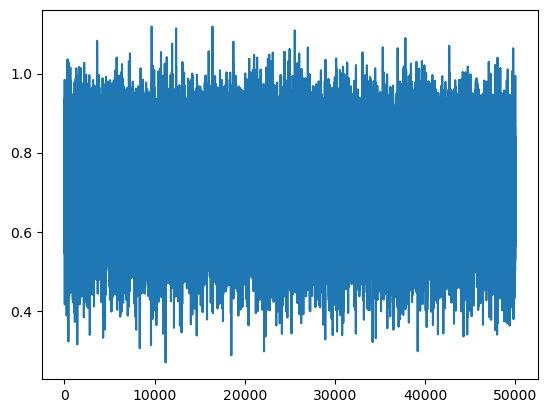

In [309]:
plt.plot(step_i, loss_i)

### GENERATING NAMES, OUR MAIN OBJECTIVE 

In [311]:
g = torch.Generator().manual_seed(2146483657)

for i in range(20):
    out = []
    context = [0] * block_size
    while True: 
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2 
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(i_to_s[i] for i in out))

cah.
cartaryn.
colekhashdakia.
rah.
faree.
bayla.
beller.
sayla.
avaree.
amid.
juvah.
moh.
kahedi.
cashleeya.
war.
fye.
niel.
daphannzion.
ash.
mayri.
